In [33]:
# Importing the necessary libraries for deep learning
"""
import keras
import tensorflow as tf
print(f"Keras version: {keras.__version__}")
print(f"TensorFlow version: {tf.__version__}")
"""

'\nimport keras\nimport tensorflow as tf\nprint(f"Keras version: {keras.__version__}")\nprint(f"TensorFlow version: {tf.__version__}")\n'

In [34]:
# Upgrading TensorFlow and Keras to the latest versions
"""
!pip install --upgrade keras
!pip install --upgrade protobuf
!pip install --upgrade tensorflow
"""

#Or

# Uninstalling previous installations of keras, protobuf, and tensorflow
"""
!pip uninstall keras
!pip uninstall protobuf
!pip uninstall tensorflow
"""

# Installing the latest versions of keras, protobuf, and tensorflow
"""
!pip install keras
!pip install protobuf
!pip install tensorflow
"""

'\n!pip install keras\n!pip install protobuf\n!pip install tensorflow\n'

In [35]:
# Re-importing the libraries to confirm successful installation and printing their versions
"""
import keras; print(keras.version)
import tensorflow; print(tensorflow.version)
"""

'\nimport keras; print(keras.version)\nimport tensorflow; print(tensorflow.version)\n'

In [36]:
# Importing additional necessary libraries and modules for image processing and machine learning
# Operating System interface for file and directory operations
import os
# OpenCV library for computer vision tasks
import cv2
# NumPy library for numerical operations on arrays and matrices
import numpy as np
# Import TensorFlow and alias it as 'tf' for ease of use
import tensorflow as tf
# Matplotlib's pyplot module for plotting graphs
import matplotlib.pyplot as plt
# PIL library for opening, manipulating, and saving many different image file formats
from PIL import Image
# Keras function to load a trained model from disk
from keras.models import load_model
# Keras function to convert an image to a numpy array
from keras.preprocessing.image import img_to_array
# TensorFlow's utility for real-time data augmentation on image data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# MobileNetV2 model from TensorFlow's applications module
from tensorflow.keras.applications import MobileNetV2
# TensorFlow's Model class to instantiate a new model
from tensorflow.keras.models import Model
# TensorFlow's layers to construct the neural network architecture
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, AveragePooling2D
# TensorFlow's Adam optimizer for training the model
from tensorflow.keras.optimizers import Adam
# MobileNetV2's preprocess_input function to preprocess images for model prediction
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
# TensorFlow's utility to convert a class vector to binary class matrix
from tensorflow.keras.utils import to_categorical
# Scikit-learn's utility for label binarization
from sklearn.preprocessing import LabelBinarizer
# Scikit-learn's function to split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split
# Scikit-learn's module to generate a report showing the main classification metrics
from sklearn.metrics import classification_report

In [37]:
# Setting initial parameters for the learning rate, number of epochs, and batch size
INIT_LR = 1e-4  # Initial Learning Rate
EPOCHS = 20     # Number of epochs to train for
BS = 32         # Batch Size

# Defining the directory path and categories for the dataset
DIRECTORY = r"D:\215179\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# Loading images from the dataset and initializing the data and labels lists
print("[INFO] loading images...")
data = []   # List to store image data
labels = [] # List to store image labels

# Looping through the categories and images, preprocessing them, and appending to the lists
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = Image.open(img_path)
        
        # Convert images with a transparency palette (mode 'P') to 'RGBA' and then to 'RGB'
        if image.mode == 'P':
            image = image.convert('RGBA').convert('RGB')
        else:
            image = image.convert('RGB')
        
        # Resize the image to the target dimensions, convert it to an array, and preprocess it
        image = image.resize((224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # Append the processed image and its corresponding label to the data and labels lists
        data.append(image)
        labels.append(category)

[INFO] loading images...


In [38]:
# One-hot encoding the labels for the two categories: with_mask and without_mask
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# Converting the data and labels into numpy arrays for the model to process
data = np.array(data, dtype="float32")
labels = np.array(labels)

# Splitting the dataset into training and testing sets with a test size of 20%
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [39]:
# Creating an image data generator for data augmentation to improve model robustness
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

In [40]:
# Loading the MobileNetV2 network, excluding the top layer, and specifying the input shape
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Constructing the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(120, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# Finalizing the model by combining the base model with the newly constructed head model
model = Model(inputs=baseModel.input, outputs=headModel)

In [41]:
# Freezing the layers of the base model to prevent them from being updated during the first training phase
!pip install  pygame
from playsound import playsound
import pygame
# Initialize pygame mixer
pygame.mixer.init()

# Start the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

# Path to the alarm sound file
alarm_sound_path = r"C:\Users\ef\OneDrive\Desktop\Face Mask Detection Project\alarm.mp3"
# Load the alarm sound
alarm_sound = pygame.mixer.Sound(alarm_sound_path)

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # Play alarm sound if no mask is detected
        if label == "No Mask":
            alarm_sound.play()

        label = f"{label}: {max(mask, withoutMask) * 100:.2f}%"
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.stop()

[INFO] compiling model...
[INFO] training head...
Epoch 1/20


95/95 [==============================] - 108s 1s/step - loss: 0.3892 - accuracy: 0.8665 - val_loss: 0.1239 - val_accuracy: 0.9791
Epoch 2/20
95/95 [==============================] - 96s 1s/step - loss: 0.1372 - accuracy: 0.9667 - val_loss: 0.0640 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 96s 1s/step - loss: 0.0924 - accuracy: 0.9753 - val_loss: 0.0411 - val_accuracy: 0.9935
Epoch 4/20
95/95 [==============================] - 96s 1s/step - loss: 0.0650 - accuracy: 0.9838 - val_loss: 0.0331 - val_accuracy: 0.9935
Epoch 5/20
95/95 [==============================] - 101s 1s/step - loss: 0.0670 - accuracy: 0.9815 - val_loss: 0.0282 - val_accuracy: 0.9935
Epoch 6/20
95/95 [==============================] - 98s 1s/step - loss: 0.0583 - accuracy: 0.9832 - val_loss: 0.0256 - val_accuracy: 0.9935
Epoch 7/20
95/95 [==============================] - 96s 1s/step - loss: 0.0575 - accuracy: 0.9855 - val_lo

In [42]:
# Evaluating the model on the testing set and printing the classification report
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

# Evaluating the model's performance on the test set
results = model.evaluate(testX, testY)
print("Test loss:", results[0])
print("Test accuracy:", results[1])

[INFO] evaluating network...
24/24 [==============================] - 17s 631ms/step
              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       383
without_mask       0.99      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767

24/24 [==============================] - 16s 659ms/step - loss: 0.0142 - accuracy: 0.9948
Test loss: 0.0141818318516016
Test accuracy: 0.9947848916053772


In [43]:
# Saving the trained model to disk in the new native Keras format
print("[INFO] saving mask detector model...")
model.save("mask_detector.model",save_format='h5')

[INFO] saving mask detector model...


C:\Users\20114\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


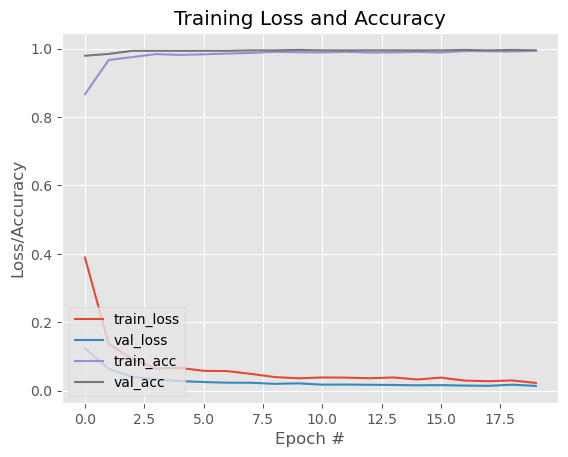

In [44]:
# Plotting the training loss and accuracy over the epochs to visualize the model's performance
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [45]:
# Importing necessary modules for image preprocessing and model loading
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# Importing modules for video stream handling and image manipulation
from imutils.video import VideoStream
import numpy as np  # For numerical operations
import imutils  # For image processing utilities
import time  # For handling time-related tasks
import cv2  # OpenCV for image and video processing
import os# For interacting with the operating system
from IPython.display import Audio

In [46]:
# Function to detect faces in a frame and predict mask usage
def detect_and_predict_mask(frame, faceNet, maskNet):
    # Obtain frame dimensions and construct a blob for face detection
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
        (104.0, 177.0, 123.0))

    # Input the blob into the network to get face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()

    # Initialize lists to hold face data, locations, and predictions
    faces = []
    locs = []
    preds = []

    # Iterate over detections and filter out weak ones based on confidence
    for i in range(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]

        # If confidence is high, compute bounding box coordinates
        if confidence > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # Ensure bounding box is within the frame dimensions
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # Extract the face ROI and preprocess it for mask prediction
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # Add the processed face and its bounding box to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # Make mask predictions on faces if any were detected
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # Return the locations of faces and their corresponding predictions
    return (locs, preds)

In [47]:
# Loading the serialized face detector model from disk
prototxtPath = r"deploy.prototxt"
weightsPath = r"res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# Loading the trained mask detection model from disk
maskNet = load_model("mask_detector.model")

In [49]:
!pip install  pygame
from playsound import playsound
import pygame
# Initialize pygame mixer
pygame.mixer.init()

# Start the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

# Path to the alarm sound file
alarm_sound_path = r"C:\Users\20114\Desktop\Face Mask Detection Project\alarm.wav"
# Load the alarm sound
alarm_sound = pygame.mixer.Sound(alarm_sound_path)

while True:
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    for (box, pred) in zip(locs, preds):
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # Play alarm sound if no mask is detected
        if label == "No Mask":
            alarm_sound.play()

        label = f"{label}: {max(mask, withoutMask) * 100:.2f}%"
        cv2.putText(frame, label, (startX, startY - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord("q"):
        break

cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
1/1 [==============================] - 0s 46ms/step
